In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from scipy.integrate import solve_ivp
import mpl_toolkits.mplot3d.axes3d as p3

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import datafold.dynfold as dfold
from datafold.dynfold import LocalRegressionSelection
from datafold.dynfold import DiffusionMaps
from datafold.utils.plot import plot_pairwise_eigenvector
import datafold.pcfold as pfold
from datafold.pcfold import PCManifold, TSCDataFrame 
from datafold.pcfold.kernels import GaussianKernel
from sklearn import (manifold, decomposition, ensemble, metrics,
                     discriminant_analysis, random_projection, neighbors)




from time import time


%load_ext autoreload
%autoreload 2

In [10]:
# Prepare train and test data
batch_size = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', 
                            train=True,
                            download=True, 
                            transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data',
                           train=False,
                           download=True,
                           transform=transform)

testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=False, num_workers=2)

# constant for classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [11]:
len(trainset)

50000

In [12]:
len(testset)

10000

# Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


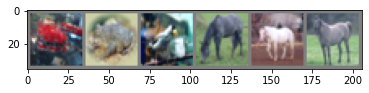

  car  frog  bird horse horse horse


In [13]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:6]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

In [14]:
# get embedding training set
for i in range(9):
    img, lab = next(iter(trainloader)) 
    images = torch.cat((images, img), 0)
    labels = torch.cat((labels, lab), 0)


images = images.numpy()
labels = labels.numpy()

In [16]:
# flatten image
images_flat = images.reshape((images.shape[0], -1))

In [20]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,8))
    ax = plt.subplot(111)
    
    tx, ty = X[:, 0], X[:, 1]
    
    for label, cls in enumerate(classes):
        y_i = [j for j, bol in enumerate(y) if bol == label]
        plt.scatter(X[y_i, 0], X[y_i, 1], color=plt.cm.Set1(label / 10.), s=12, label=classes[label], alpha=0.8)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


In [21]:
def plot_3D_embedding(X, y, rotate=None, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.scatter(*X.T, c=plt.cm.Set1(y / 10.))
    if rotate is not None:
        a, b = rotate
        ax.view_init(a, b)

    if title is not None:
        ax.set_title(title)

# PCA

Computing PCA projection
[0.291471   0.11533862]


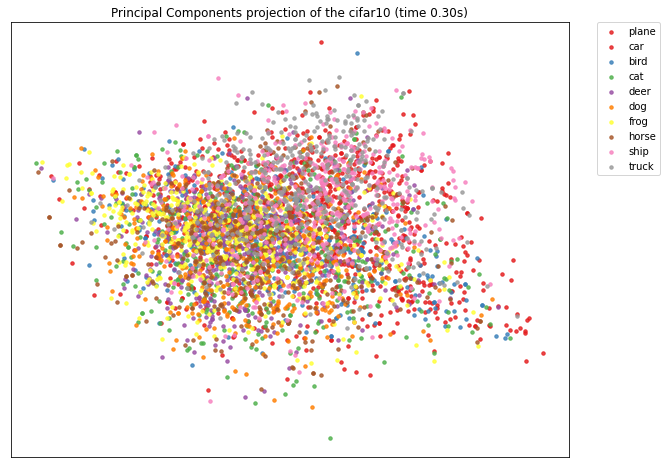

In [37]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
pca = decomposition.TruncatedSVD(n_components=2)
X_pca = pca.fit_transform(images_flat)
print(pca.explained_variance_ratio_)
plot_embedding(X_pca, labels,
               "Principal Components projection of the cifar10 (time %.2fs)" %
               (time() - t0))

## KNN on PCA

In [52]:
knn = neighbors.KNeighborsClassifier(n_neighbors=21)
# Train the model using the training sets
knn.fit(X_pca, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [53]:
# get test set
dataiter_test = iter(testloader)
test_images, test_labels = dataiter_test.next()
test_images_flat = test_images.reshape((batch_size, -1))
X_pca_test = pca.transform(test_images_flat)

#Predict Output
predicted= knn.predict(X_pca_test) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, predicted))

Accuracy: 0.188


# t-SNE embedding

Computing t-SNE embedding


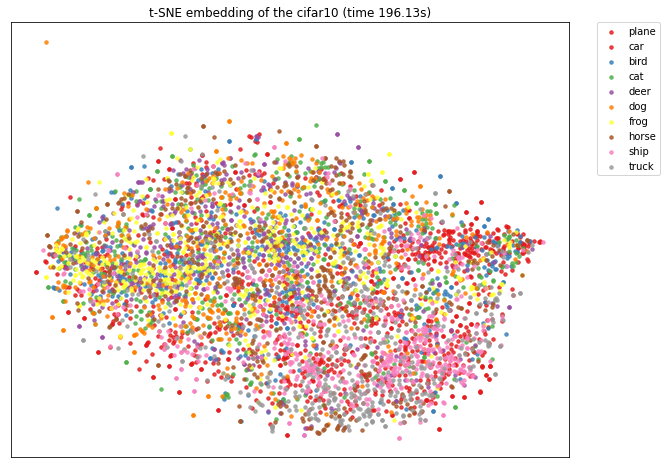

In [71]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(images_flat)

plot_embedding(X_tsne, labels,
               "t-SNE embedding of the cifar10 (time %.2fs)" %
               (time() - t0))

## KNN on t-SNE embedding

In [304]:
knn = neighbors.KNeighborsClassifier(n_neighbors=41)
# Train the model using the training sets
knn.fit(X_tsne, labels)

X_tsne_test = tsne.fit_transform(test_images_flat)

#Predict Output
predicted= knn.predict(X_tsne_test) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, predicted))

Accuracy: 0.102


# Diffusion map embedding

In [242]:
# optimize the parameters 
X_pcm = pfold.PCManifold(images_flat)
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

epsilon=302.16297451328387, cut-off=74.60594940185547


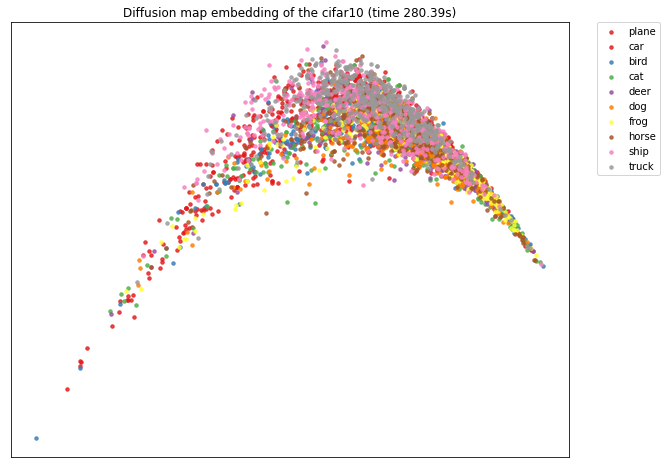

In [243]:
t0 = time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon), 
                     n_eigenpairs=10, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap = dmap.transform(X_pcm)

# Mapping of diffusion maps
plot_embedding(X_dmap, labels, title="Diffusion map embedding of the cifar10 (time %.2fs)" % (time() - t0))

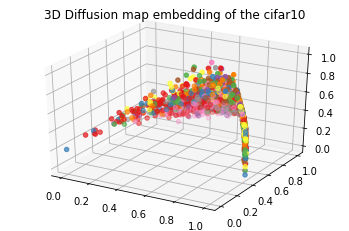

In [297]:
t0 = time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon), 
                     n_eigenpairs=10, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2, 3])
X_dmap = dmap.transform(X_pcm)

# Mapping 3D diffusion maps
plot_3D_embedding(X_dmap, labels, title="3D Diffusion map embedding of the cifar10")

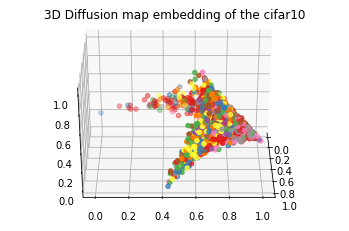

In [298]:
# Mapping 3D diffusion maps
plot_3D_embedding(X_dmap, labels, [30, 0], title="3D Diffusion map embedding of the cifar10")

## Compare different embeddings

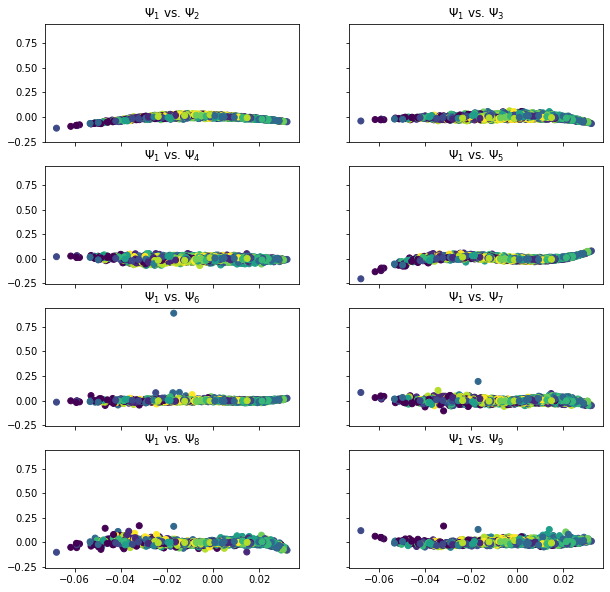

In [258]:
# Compare different embeddings
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon), n_eigenpairs=10, dist_kwargs=dict(cut_off=X_pcm.cut_off))
dmap = dmap.fit(X_pcm)
plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[:, 1:], 
                          n=0,
                          idx_start=1,
                          fig_params=dict(figsize=(10,10)), 
                          scatter_params=dict(c=labels))

## plot test embedding

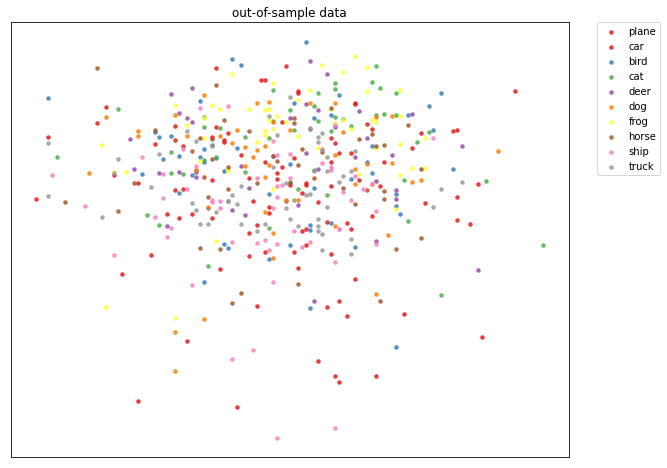

In [259]:
X_dmap_test = dmap.transform(test_images_flat)
plot_embedding(X_dmap_test, test_labels, title="out-of-sample data")

## KNN on diffusion maps

In [257]:
knn = neighbors.KNeighborsClassifier(n_neighbors=23)
# Train the model using the training sets
knn.fit(X_dmap, labels)

#Predict Output
predicted= knn.predict(X_dmap_test) 

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, predicted))

Accuracy: 0.242


## Linear classify on diffusion maps

In [73]:
from models.nn_dmap import NN_DMap
from utils.train import train
from utils.test import test

dmap_model = NN_DMap()
train(dmap_model, trainloader)
test(dmap_model, testloader)

Start training!
Epoch: 1 	 Training Loss:2.305944
Epoch: 2 	 Training Loss:2.303592
Epoch: 3 	 Training Loss:2.302321
Epoch: 4 	 Training Loss:2.300584
Epoch: 5 	 Training Loss:2.299779
Epoch: 6 	 Training Loss:2.298786
Epoch: 7 	 Training Loss:2.297515
Epoch: 8 	 Training Loss:2.296468
Epoch: 9 	 Training Loss:2.295234
Epoch: 10 	 Training Loss:2.293736
Finish training! time 2747.23s

Total Accuracy: 17 %
Accuracy of plane : 50.000000 %
Accuracy of   car : 11.111111 %
Accuracy of  bird : 22.222222 %
Accuracy of   cat : 0.000000 %
Accuracy of  deer : 8.333333 %
Accuracy of   dog : 50.000000 %
Accuracy of  frog : 0.000000 %
Accuracy of horse : 0.000000 %
Accuracy of  ship : 26.666667 %
Accuracy of truck : 25.000000 %
